In [ ]:
T0 = 2.725 #taken from the paper
K = (9.88 * 10**(-8))/0.022
a = (2/5) * K

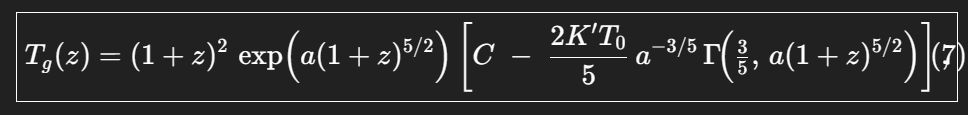

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaincc, gamma  # for lower incomplete gamma Γ(s,x) = gammainc(s,x)*gamma(s)

In [ ]:
# We'll sample z logarithmically between 10 and 1000
z = np.logspace(np.log10(10), np.log10(1000), 500)

In [ ]:
# Step 3: Compute T_gamma (CMB temperature)
# ----------------------------
T_gamma = T0 * (1 + z)   # Grows linearly with (1+z)

In [ ]:
def Gamma_upper(s, x):
    return gammaincc(s, x) * gamma(s)

In [ ]:
z_i = 1000.0
u_i = 1.0 + z_i
x_i = a * (u_i**2.5)  # argument of Γ(3/5, ...)
# Compute C from: T0*u_i = u_i^2 * exp[a u_i^(5/2)] * [ C - (2 K' T0 / 5) * a^(-3/5) * Γ(3/5, x_i) ]
C = (T0 * u_i) / (u_i**2 * np.exp(x_i)) - (2.0 * K * T0 / 5.0) * (a**(-3.0/5.0)) * Gamma_upper(3.0/5.0, x_i)
print(C)

3.458445142325188e-30


In [ ]:
# Step 4: Compute T_g (gas temperature) using the derived analytical formula
# ----------------------------
T_g = (1+z)**2 * np.exp(a * ((1+z)**2.5)) * (C + (2.0 * K * T0 / 5.0) * (a**(-3.0/5.0)) * Gamma_upper(3.0/5.0, (a * ((1+z)**2.5))))

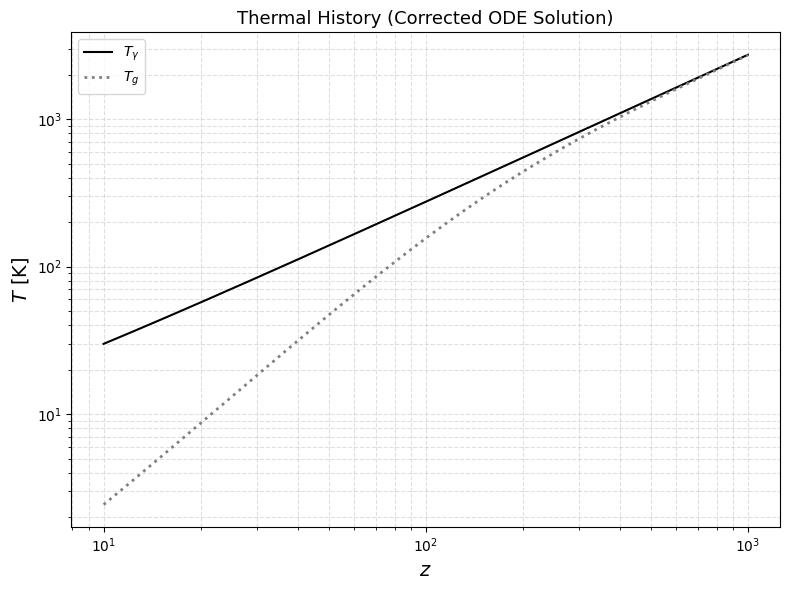

In [ ]:
# Step 5: Create the plot
# ----------------------------
plt.figure(figsize=(8,6))

# Solid black: T_gamma
plt.plot(z, T_gamma, color='black', label=r'$T_\gamma$')

# Dotted gray: T_g
plt.plot(z, T_g, color='gray', linestyle=':', linewidth=2.0, label=r'$T_g$')

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$z$', fontsize=14)
plt.ylabel(r'$T\ \mathrm{[K]}$', fontsize=14)
plt.title('Thermal History (Corrected ODE Solution)', fontsize=13)

plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()

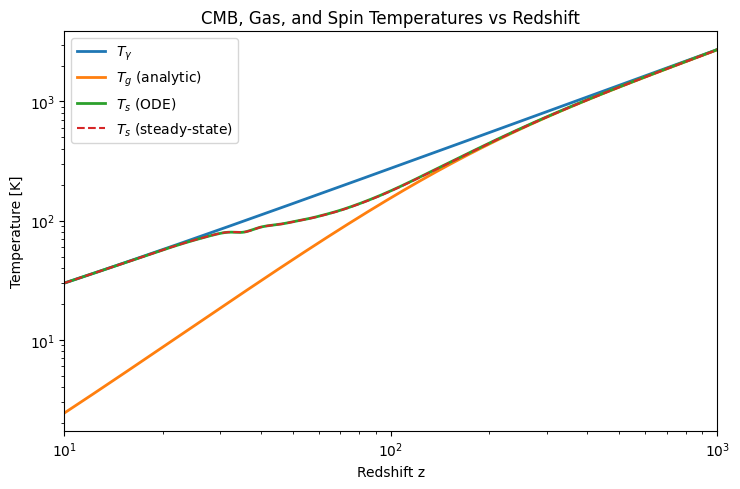

In [ ]:
# ------------------------------------------------------------
# Spin temperature Ts(z) from Bharadwaj & Ali (2004), eq. (4)
# ------------------------------------------------------------
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from scipy.special import gamma, gammaincc   # for upper incomplete Gamma

# -----------------------------
# 0) Physical & cosmological constants
# -----------------------------
k_B   = 1.380649e-16    # erg/K
h_P   = 6.62607015e-27  # erg*s
c     = 2.99792458e10   # cm/s
nu21  = 1420.405751e6   # Hz
T_star = h_P*nu21/k_B   # 21-cm equivalent temperature [K] ~ 0.068
A10   = 2.85e-15        # s^-1 (Einstein A-coefficient)

# Cosmology (paper's choice): (Om, OL, Ob*h^2, h) = (0.3, 0.7, 0.02, 0.7)
h = 0.7
H0_km_s_Mpc = 100.0*h
H0 = H0_km_s_Mpc*1.0e5/(3.0856775814913673e24)  # s^-1
Om, OL = 0.3, 0.7

# Include radiation for z~1000 (good practice)
Tcmb0 = 2.725  # K
Omega_gamma_h2 = 2.472e-5 * (Tcmb0/2.725)**4
Og = Omega_gamma_h2 / h**2
Neff = 3.046
Or = Og*(1.0 + 0.2271*Neff)   # photons + neutrinos

# Baryons & hydrogen density today
Ob_h2 = 0.02
Ob = Ob_h2 / h**2
rho_c0 = 1.8788e-29 * h**2       # g/cm^3
X_H = 0.76                       # hydrogen mass fraction
m_p = 1.67262192369e-24          # g
nH0 = X_H * Ob * rho_c0 / m_p    # cm^-3  (≈1.9e-7 cm^-3 for these params)

# -----------------------------
# 1) Background functions
# -----------------------------
def H_of_z(z):
    """Hubble rate [s^-1]."""
    return H0*np.sqrt(Or*(1+z)**4 + Om*(1+z)**3 + OL)

def T_cmb(z):
    return Tcmb0*(1.0 + z)

# -----------------------------
# 1b) Your analytic Tg(z)
#     NOTE: a, C, K, T0 are assumed already defined in your notebook.
#     We compute the UPPER incomplete gamma: Γ(3/5, x) = gamma(3/5) * gammaincc(3/5, x)
# -----------------------------
USE_YOUR_Tg = True

def Tg_user(z):
    """
    Analytic gas temperature:
    Tg(z) = (1+z)^2 * exp[a*(1+z)^(5/2)] *
            [ C - (2*K*T0/5) * a^(-3/5) * Γ(3/5, a*(1+z)^(5/2)) ].

    Uses global variables a, C, K, T0 defined in your notebook.
    """
    z = np.asarray(z, dtype=float)
    one_p_z = 1.0 + z
    x = a * (one_p_z**2.5)                           # argument of Γ
    #Gamma_upper = gamma(3.0/5.0) * gammaincc(3.0/5.0, x)  # Γ(3/5, x)
    bracket = C + (2.0*K*T0/5.0) * (a**(-3.0/5.0)) * Gamma_upper (3.0/5.0, x)
    return (one_p_z**2) * np.exp(x) * bracket

# -----------------------------
# 2) Allison & Dalgarno (1969) κ10(T) table (cm^3 s^-1) + log–log spline
# -----------------------------
T_tab = np.array([  1,   2,   4,    6,    8,    10,   15,   20,   25,   30,
                   40,  50,  60,   70,   80,    90,  100,  200,  300,  400,
                  500, 600, 700,  800,  900, 1000], dtype=float)
k_tab = np.array([2.2e-14, 4.2e-14, 1.8e-13, 5.1e-13, 1.2e-12, 2.3e-12, 7.4e-12,
                  1.5e-11, 3.3e-11, 3.4e-11, 4.6e-11, 5.6e-11, 6.6e-11, 7.4e-11,
                  8.2e-11, 8.9e-11, 9.5e-11, 1.4e-10, 1.6e-10, 1.8e-10, 1.8e-10,
                  2.1e-10, 2.2e-10, 2.3e-10, 2.4e-10, 2.5e-10], dtype=float)

logT_spl = InterpolatedUnivariateSpline(np.log(T_tab), np.log(k_tab), k=3)
def kappa10(T):
    T = np.clip(np.array(T, ndmin=1), T_tab[0], T_tab[-1])
    return np.exp(logT_spl(np.log(T)))

# -----------------------------
# 3) n_H(z) and C10(z)
# -----------------------------
def nH_z(z):
    return nH0*(1.0 + z)**3   # cm^-3

def C10_of(z, Tg_val):
    """C10 = (4/3) κ10(Tg) nH  [s^-1]."""
    return (4.0/3.0)*kappa10(Tg_val)*nH_z(z)

# -----------------------------
# 4) Exact ODE for y(z)=1/Ts(z) from eq. (4)
# -----------------------------
def d_y_dz(z, y, Tg_val):
    # y=1/Ts; eq. (4)
    C10 = C10_of(z, Tg_val)
    Tcmb = T_cmb(z)
    return -(4.0/(H_of_z(z)*(1.0+z))) * (
        (1.0/Tg_val - y)*C10 + (1.0/Tcmb - y)*(Tcmb/T_star)*A10
    )

def integrate_Ts_ODE(z_grid, Tg_grid):
    # integrate from high z downwards: y(z_i)=1/Tcmb(z_i)
    z_sorted = np.array(z_grid)[::-1]      # descending for IVP
    Tg_sorted = np.array(Tg_grid)[::-1]
    y0 = 1.0/T_cmb(z_sorted[0])

    # Piecewise-constant Tg within each step (accurate for fine sampling)
    y_vals = [y0]
    for i in range(len(z_sorted)-1):
        z1, z0 = z_sorted[i+1], z_sorted[i]
        Tg_mid = 0.5*(Tg_sorted[i] + Tg_sorted[i+1])
        rhs = lambda zz, yy: d_y_dz(zz, yy, Tg_mid)
        #sol = solve_ivp(rhs, (z0, z1), [y_vals[-1]], rtol=1e-8, atol=1e-10)
        sol = solve_ivp(rhs, (z0, z1), [y_vals[-1]],
                       method='DOP853',  # Higher order method
                       rtol=1e-9, atol=1e-11)
        y_vals.append(sol.y[0, -1])
    y_vals = np.array(y_vals)
    # Flip back to ascending z
    return 1.0/y_vals[::-1]    # Ts = 1/y

# -----------------------------
# 5) Steady-state (Field) Ts for comparison:
#     1/Ts = (1/Tcmb + x_c/Tg) / (1 + x_c),  x_c = (C10*T*)/(A10*Tcmb)
# -----------------------------
def Ts_field(z, Tg_val):
    Tcmb = T_cmb(z)
    C10 = C10_of(z, Tg_val)
    x_c = (C10*T_star)/(A10*Tcmb)
    invTs = (1.0/Tcmb + x_c*(1.0/Tg_val))/(1.0 + x_c)
    return 1.0/invTs

# -----------------------------
# 6) Driver: assemble and plot
# -----------------------------
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # redshift grid (increasing 10 -> 1000)
    zmin, zmax = 10.0, 1000.0
    z = np.geomspace(zmin, zmax, 600)  # ascending by default

    # Gas temperature Tg(z): USE THE ANALYTIC FORM EVERYWHERE
    if USE_YOUR_Tg:
        Tg = Tg_user(z)
    else:
        Tg = Tg_from_ode(z, z_ini=zmax)

    # Exact ODE solution for Ts
    Ts_ode = integrate_Ts_ODE(z, Tg)

    # Steady-state Ts (should closely track Ts_ode)
    Ts_ss = Ts_field(z, Tg)

    # CMB temperature
    Tcmb = T_cmb(z)

    # ---- Plot ----
    plt.figure(figsize=(7.5,5))
    plt.loglog(z, Tcmb, label=r'$T_\gamma$', lw=2)
    plt.loglog(z, Tg,    label=r'$T_g$ (analytic)', lw=2)
    plt.loglog(z, Ts_ode, label=r'$T_s$ (ODE)', lw=2)
    plt.loglog(z, Ts_ss,  '--', label=r'$T_s$ (steady-state)', lw=1.5)

    plt.xlim(zmin, zmax)          # increasing axis 10 -> 100
    plt.xlabel('Redshift z')
    plt.ylabel('Temperature [K]')
    plt.legend()
    plt.title('CMB, Gas, and Spin Temperatures vs Redshift')
    plt.tight_layout()


In [ ]:
+